In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

def eda(Xt, Yt, Xtest, Ytest):
    print(Xt.shape, Yt.shape)
    print(Xtest.shape, Ytest.shape)

    print(Xt.dtype, Yt.dtype)
    print(Xtest.dtype, Ytest.dtype)

    plt.figure(figsize=(7,2))
    plt.subplot(121)
    plt.hist(Yt)
    plt.subplot(122)
    plt.hist(Ytest)
    plt.show()

    print('clase, Ytest/Yt, Nt, Ntest')
    for i in range(5):
        strain, stest = (Yt == i).sum(), (Ytest == i).sum()
        p = round(stest/strain, 4)
        print(i, p, strain, stest)

    print()
    print('statistics')
    print(Xt.mean(), Xt.std(), Xt.min(), Xt.max())
    print(Xtest.mean(), Xtest.std(), Xtest.min(), Xtest.max())

import sklearn as sk
from mlxtend.evaluate import accuracy_score

def evaluation(classifier, Ytest, Ypred, tree=False):
    std_acc = accuracy_score(Ytest, Ypred)
    avg_acc = accuracy_score(Ytest, Ypred, method='average')
    bin_acc0 = accuracy_score(Ytest, Ypred, method='binary', pos_label=0)
    bin_acc1 = accuracy_score(Ytest, Ypred, method='binary', pos_label=1)
    bin_acc2 = accuracy_score(Ytest, Ypred, method='binary', pos_label=2)
    bin_acc3 = accuracy_score(Ytest, Ypred, method='binary', pos_label=3)
    bin_acc4 = accuracy_score(Ytest, Ypred, method='binary', pos_label=4)
    class_precision = sk.metrics.precision_score (Ytest, Ypred, average = None)
    recall = sk.metrics.recall_score(Ytest, Ypred, average= None)
    f1macro = sk.metrics.f1_score(Ytest, Ypred, average="macro")

    print(f'f1-macro:                   {f1macro:.4f}')
    print(f'Standard accuracy:          {std_acc:.4f}')
    print(f'Average per-class accuracy: {avg_acc:.4f}')
    print ()
    print(f'Normal accuracy: {bin_acc0:.4f}')
    print(f'DoS accuracy:    {bin_acc1:.4f}')
    print(f'Probe accuracy:  {bin_acc2:.4f}')
    print(f'R2L accuracy:    {bin_acc3:.4f}')
    print(f'U2R accuracy:    {bin_acc4:.4f}')
    print()
    print(f"Normal Precision: {class_precision[0]:.4f}")
    print(f"DoS Precision:    {class_precision[1]:.4f}")
    print(f"Probe Precision:  {class_precision[2]:.4f}")
    print(f"R2L Precision:    {class_precision[3]:.4f}")
    print(f"U2R Precision:    {class_precision[4]:.4f}")
    print()
    print(f"Normal Recall: {recall[0]:.4f}")
    print(f"DoS Recall:    {recall[1]:.4f}")
    print(f"Probe Recall:  {recall[2]:.4f}")
    print(f"R2L Recall:    {recall[3]:.4f}")
    print(f"U2R Recall:    {recall[4]:.4f}")

    confusion_matrix = sk.metrics.confusion_matrix(Ytest, Ypred)
    cm_display = sk.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show()

    if tree:
        sk.tree.plot_tree(classifier, fontsize=1)
    return None

### Resampled split

(126239, 122) (126239,)
(22278, 122) (22278,)
float64 float64
float64 float64


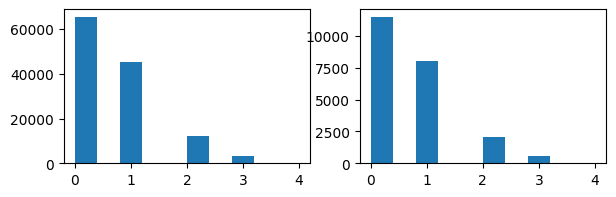

clase, Ytest/Yt, Nt, Ntest
0 0.1759 65529 11525
1 0.1782 45313 8074
2 0.1745 11986 2091
3 0.1719 3311 569
4 0.19 100 19

statistics
0.06622127810179455 0.24043281002177241 0.0 1.0000000000000002
0.06630302044916142 0.2405701021576793 0.0 1.0


In [ ]:
import numpy as np
from sklearn.utils import shuffle

dsname = "normal_attacks_resampled"
data = np.load("datasets/dataset_2.npz")
Xt, Yt = shuffle(data["X_train"], data["Y_train"], random_state=0)
Xtest = data["X_test"]
Ytest = data["Y_test"]

eda(Xt, Yt, Xtest, Ytest)

In [ ]:
### Methods to reduce dataset size

def rss(Xtrain, Ytrain, size, clf):
    """ Random Selection Strategy """
    indices = np.random.choice(len(Xtrain), size=size, replace=False)
    x, y = Xtrain[indices], Ytrain[indices]
    clf.fit(x, y)
    return x, y, clf

def rss_xgboost(Xtrain, Ytrain, size, clf):
    """ Random Selection Strategy """
    Xt_shuffled, Yt_shuffled = shuffle(Xtrain, Ytrain)
    _, unique_indices = np.unique(Yt_shuffled, return_index=True)
    x0, y0 = Xt_shuffled[unique_indices], Yt_shuffled[unique_indices]

    indices = np.random.choice(len(Xtrain), size=size, replace=False)
    x = np.concatenate([x0, Xtrain[indices]])
    y = np.concatenate([y0, Ytrain[indices]])
    clf.fit(x, y)
    return x, y, clf

def addOnlyErrors(Xtrain, Ytrain, batch_size, n_epochs, clf):
    """ Selection strategy based on adding only errors """
    # Initialization
    Xt_shuffled, Yt_shuffled = shuffle(Xtrain, Ytrain)
    _, unique_indices = np.unique(Yt_shuffled, return_index=True)
    x, y = Xt_shuffled[unique_indices], Yt_shuffled[unique_indices]
    clf.fit(x, y)
    for _ in range(n_epochs):
        Xt_shuffled, Yt_shuffled = shuffle(Xtrain, Ytrain)
        for i in range(0, len(Xt_shuffled), batch_size):
            # Add errors of the next batch
            dx, dy = Xt_shuffled[i:i+batch_size], Yt_shuffled[i:i+batch_size]
            dypred = clf.predict(dx)
            x = np.concatenate([x, dx[dypred != dy, :]])
            y = np.concatenate([y, dy[dypred != dy]])
            clf.fit(x, y)
    return x, y, clf


import time
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tabpfn import TabPFNClassifier
#from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

class CatBoostClassifierv2(CatBoostClassifier):
    def predict(self, x):
        y = super().predict(x)
        return np.squeeze(y)

clfs = {'dtree': lambda seed: DecisionTreeClassifier(random_state=seed),
        'svm': lambda seed: svm.SVC(random_state=seed),
        'xgboost': lambda seed: XGBClassifier(seed=seed),
        'randomforest': lambda seed: RandomForestClassifier(random_state=seed),
        'catboost': lambda seed: CatBoostClassifierv2(random_state=seed, verbose=0),
        #'mlp': lambda seed: MLPClassifier(random_state=seed, max_iter=300),
        'tabpfn': lambda seed: TabPFNClassifier(random_state=seed),  # Debo limitar el nuero de instacias < 10000
        #'autotabpfn': lambda seed: AutoTabPFNClassifier(random_state=seed, max_time=30, device="cuda"),  # Debo limitar el nuero de instacias < 10000
}

In [7]:
bs_values = [100, 1000, 10000, 100000, 1000000]
Nseeds = 100
n_epochs = 1
clflabels = ["catboost"]

outdir = f"outputsv3/{dsname}/"
Path(outdir).mkdir(parents=True, exist_ok=True)
columns = ["f1-aoe", "f1-c", "f1-rss", "t-aoe", "t-c", "t-rss", "Nds-aoe"]
# aoe: addonlyerrors, c: complete, rss: random selection strategy
# t: training time, f1: f1-score macro, Nds: dataset size, bs: batch size
for clflabel in clflabels:
    stats = pd.DataFrame(bs_values, columns=["bs"])
    for column in columns:
        stats[column + " (m)"] = None
    for column in columns:
        stats[column + " (s)"] = None

    for irow, row in stats.iterrows():
        metrics = {column: [] for column in columns}
        for _ in tqdm(range(Nseeds)):

            # Add Only Errors Strategy
            x0 = time.time()
            xr, yr, clf_aoe = addOnlyErrors(Xt, Yt, row["bs"], n_epochs, clfs[clflabel](seed=None))
            metrics["t-aoe"].append(time.time()-x0)
            Ypred = clf_aoe.predict(Xtest)
            metrics["f1-aoe"].append(f1_score(Ytest, Ypred, average='macro'))
            metrics["Nds-aoe"].append(xr.shape[0])
            del clf_aoe

            # Complete dataset
            clf_c = clfs[clflabel](seed=None)
            x0 = time.time()
            clf_c.fit(Xt, Yt)
            metrics["t-c"].append(time.time()-x0)
            Ypred = clf_c.predict(Xtest)
            metrics["f1-c"].append(f1_score(Ytest, Ypred, average='macro'))
            del clf_c

            # Random Selection Strategy
            x0 = time.time()
            _, _, clf_rss = rss(Xt, Yt, xr.shape[0], clfs[clflabel](seed=None))
            metrics["t-rss"].append(time.time()-x0)
            Ypred = clf_rss.predict(Xtest)
            metrics["f1-rss"].append(f1_score(Ytest, Ypred, average='macro'))
            del clf_rss

        metrics_df = pd.DataFrame.from_dict(metrics)
        stats.iloc[irow] = [row["bs"]] + metrics_df.mean().tolist() + metrics_df.std().tolist()

    print(f"Results for {clflabel} classifier:")
    stats.to_csv(outdir + f"{clflabel}.csv", index=False)
    display(stats)

100%|██████████| 100/100 [1:21:27<00:00, 48.88s/it]

Results for catboost classifier:


,bs,f1-aoe (m),f1-c (m),f1-rss (m),t-aoe (m),t-c (m),t-rss (m),Nds-aoe (m),f1-aoe (s),f1-c (s),f1-rss (s),t-aoe (s),t-c (s),t-rss (s),Nds-aoe (s)
0,100,0.994706,0.999798,0.719575,2095.439931,21.196803,1.662258,247.01,0.00506,0.0,0.041679,101.903575,0.42449,0.112705,13.547146
1,1000,0.99317,0.999798,0.770893,361.121091,20.932049,2.751043,651.34,0.00593,0.0,0.038828,48.525187,0.136228,0.354782,162.878229
2,10000,0.994067,0.999798,0.892025,68.430018,21.011969,4.784456,5286.87,0.00529,0.0,0.050474,6.295341,0.157189,0.51698,1701.621762
3,100000,0.987558,0.999798,0.974855,23.853315,21.033706,8.803228,40673.99,0.009107,0.0,0.014591,3.953007,0.166591,2.031824,15463.052783
4,1000000,0.823264,0.999798,0.975091,15.784627,21.013808,9.277692,43754.97,0.10783,0.0,0.017416,2.649253,0.183994,2.639908,19334.824536


In [ ]:
import shutil


carpeta_origen = "/content/outputsv3/"
archivo_zip_salida = f"/content/outputsv3"
shutil.make_archive(archivo_zip_salida, 'zip', carpeta_origen)

print(f"Archivo ZIP creado: {archivo_zip_salida}.zip")
from google.colab import files
files.download(f"{archivo_zip_salida}.zip")